**Package Imports**

In [ ]:
# !pip install bayesian-optimization

In [ ]:
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
from   zipfile    import ZipFile
from   datetime   import datetime
import random
import re
import time

from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score
from sklearn.decomposition   import PCA

from bayes_opt               import BayesianOptimization
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import accuracy_score, make_scorer, roc_auc_score, log_loss
from sklearn.utils           import class_weight
from xgboost                 import XGBClassifier

# import xgboost as xgb
import tensorflow as tf
from boruta import BorutaPy

2023-08-20 18:03:34.996108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Google Drive Code**

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files = files.upload()

# ! mkdir ~/.kaggle          # Making New File Directory
# !cp kaggle.json ~/.kaggle/ # New File Path
# ! chmod 600 ~/.kaggle/kaggle.json  ## Permission

# !kaggle datasets download -d brandao/diabetes

**Diabetes File Load**

In [ ]:
def load_datasets():
  with ZipFile('diabetes.zip') as zip:
    print(zip.namelist())
    with zip.open(zip.namelist()[1]) as csv:
      data = pd.read_csv(csv)

  targets = data['readmitted']
  x_data  = data[data.columns[2:len(data.columns)-1]]

  return targets, x_data

targets, x_data = load_datasets()

# data = data.drop(columns = ['index'])
# data['Patient Id'] = pd.factorize(data['Patient Id'])[0]

['description.pdf', 'diabetic_data.csv']


In [ ]:
# Understand How Many Values Are Missing
# For each category -- Possible drop candidates
def get_missing_counts():

	missing_columns = []
	print('Dataset Full Length: ', len(x_data.index))
	for col in x_data.columns:
		count = x_data[col].value_counts().get('?', 0) # get() returns 0 if '?' is not found
		print(f"Column {col} has {count} '?' values")

		if float(count) > 0:
			missing_columns.append(col)

	return missing_columns

missing_columns = get_missing_counts()

In [ ]:
# Drop Columns Based on Missing Values...
# if 1/3rd of dataset is missing values drop
# Pointless to impute that many values

def missing_drop(x_data):

	# A1Cresult has "None" ~ ? for most values
	col_drops = ['weight', 'medical_specialty', 'payer_code', 'A1Cresult']
	x_data = x_data.drop(columns = col_drops)

	return x_data

x_data = missing_drop(x_data)

In [ ]:
# Fill in missing values for columns that
# Were not dropped in missing_drop()

from sklearn.impute import SimpleImputer

def fill_missing(x_data, missing_columns):

	missing_columns = [col for col in missing_columns if col in x_data]
	x_data[missing_columns].replace('?', np.nan, inplace = True)
	print(missing_columns)
	for col in missing_columns:
		imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
		x_data[col] = imputer.fit_transform(np.array(x_data[col]).reshape(-1, 1))


	return x_data

x_data = fill_missing(x_data, missing_columns)

['race', 'diag_1', 'diag_2', 'diag_3']


/var/folders/ht/6l5r0flj7cz0trk5ctm_h1v80000gn/T/ipykernel_35136/1140767665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data[missing_columns].replace('?', np.nan, inplace = True)


**Changing Diagnoses Columns**
1. ICD9 defines ranges of codes, so let's reduce the amount of variables in these columns
2. https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [ ]:
[print(x_data[col].value_counts()) for col in x_data]

In [ ]:
infectious          = range(0, 140)
neoplasms           = range(140, 240)
endo_mental_blood   = range(240, 320)
nervous_system      = range(320, 390)
circulatory         = range(390, 460)
respiratory         = range(460, 520)
digestive           = range(520, 580)
gentinory_pregnancy = range(580, 680)
skin                = range(680, 710)
musculoskeletal     = range(710, 740)
congenital          = range(740, 760)
perinatal_undef     = range(760, 800)
injury              = range(800, 1000)


def categorize_diagnosis(data):

  value      = None

  new_values = []
  for entry in data:
    try:
      entry    = float(entry)
      entry    = round(entry, 0)
      entry    = int(entry)
    except ValueError:
      value    = 13

    if entry in infectious:
      value  = 0
    elif entry in neoplasms:
      value  = 1
    elif entry in endo_mental_blood:
      value  = 2
    elif entry in nervous_system:
      value  = 3
    elif entry in circulatory:
      value  = 4
    elif entry in respiratory:
      value = 5
    elif entry in digestive:
      value = 6
    elif entry in gentinory_pregnancy:
      value = 7
    elif entry in skin:
      value = 8
    elif entry in musculoskeletal:
      value = 9
    elif entry in congenital:
      value = 10
    elif entry in perinatal_undef:
      value = 11
    elif entry in injury:
      value = 12

    new_values.append(value)

  return new_values
# Define the bins and their labels
# bins   = [0, 139, 279, 419, 559, 699, 800]
# labels = ['Infectious Diseases', 'Another Category', 'Third Category', 'Fourth Category', 'Fifth Category', 'Other']

# # Create a new column in the DataFrame with the category
# dataset['category'] = pd.cut(dataset['column_name'], bins=bins, labels=labels, right=True, include_lowest=True)


new_diag1            = categorize_diagnosis(x_data['diag_1'])
new_diag2            = categorize_diagnosis(x_data['diag_2'])
new_diag3            = categorize_diagnosis(x_data['diag_3'])

x_data['diag_1']     = new_diag1
x_data['diag_2']     = new_diag2
x_data['diag_3']     = new_diag3


def create_risk(x_data, drop = True):
    x_data['Patient Risk'] = x_data['time_in_hospital'] + x_data['num_lab_procedures']\
                    + x_data['num_procedures']

    if drop:
      x_data = x_data.drop(columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures'])

    return x_data


x_data = create_risk(x_data, drop = True)

In [ ]:
def create_utilization(x_data, drop = True):

	utilization_columns = ['number_inpatient', 'number_emergency', 'number_outpatient']
	x_data['Patient Utilization'] = x_data['number_inpatient'] + x_data['number_emergency'] + x_data['number_outpatient']

	if drop:
		x_data = x_data.drop(columns = utilization_columns)

	return x_data


x_data = create_utilization(x_data, drop = True)

In [ ]:
def simplify_admission_id(data):

  data['admission_source_id'] = data['admission_source_id'].map(lambda x: 0 if x in [0, 1] else 1)

  return data

x_data = simplify_admission_id(x_data)

In [ ]:
# no users or almost no users so dropping these
# Drop parameter determines whether drop happens
# Features are chosen later with variance threshold

def drop_low_use(x_data, drop = False):

  if drop:
    low_use_medicines = ['metformin-rosiglitazone', 'glimepiride-pioglitazone',
                        'glipizide-metformin', 'tolazamide', 'examide',
                        'miglitol', 'glimepiride']

    x_data            = x_data.drop(columns = low_use_medicines)

  return x_data

# x_data = drop_low_use(x_data)


**Targets**

In [ ]:
# Spit the datasets into the x_data and into Training Sets

def create_datasets(binary_targets, encoding_scheme = 'Kaggle'):

  experimental_length = len(x_data.index)
  x_training          = x_data

  target_factorized   = pd.factorize(targets[:experimental_length])[0]
  target_label        = pd.factorize(targets[:experimental_length])[1]

  if encoding_scheme == 'Kaggle':
     removal_value    = 1 # Represents > 30 days readmission
  else:
     removal_value    = 2  # Represents < 30 days readmission

  if binary_targets and removal_value == 2:
    target_factorized = np.array([item if item != removal_value else 1 for item in target_factorized])

  elif binary_targets and removal_value == 1:
    target_factorized  = np.array([item if item != removal_value else 0 for item in target_factorized])
    target_factorized  = pd.Series(target_factorized)
    target_factorized  = target_factorized.apply(lambda x: 0 if x == 0 else 1)
    target_factorized  = np.array(target_factorized)

  else:
     pass

  x_factorized        = [pd.factorize(x_training[col])[0] for col in list(x_training.columns)]
  x_labels            = [pd.factorize(x_training[col])[1] for col in list(x_training.columns)]

  for col in range(len(x_training.columns)):
      x_training[x_training.columns[col]]    = x_factorized[col]
      x_training                             = x_training[:experimental_length]


  return target_factorized, x_training


binary_targets      = True             # Readmitted vs Non readmitted (ignoring period of readmission)
target_factorized, x_training = create_datasets(binary_targets)

**Removing Features**

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
import math

# Resetting the value of X to make it non-categorical
# X = array[:, 0:8]

class FeatureSelection:

    def __init__(self, x_training, target_factorized, selection_method = 'kbest'):

      self.x_training        = x_training
      self.target_factorized = target_factorized
      self.selection_method  = selection_method


    def feature_select(self, x_training, target_factorized, min_features = 2, max_features = 20, selection_method = 'kbest'):

      if selection_method == 'kbest':
        x_trainings = []

        for feature in range(min_features, max_features):
          k_best_features = SelectKBest(chi2, k=feature)
          x_train_thresh = k_best_features.fit_transform(x_training, target_factorized)

          x_train_thresh = pd.DataFrame(x_train_thresh)


          column_names   = []

          index_columns = k_best_features.get_support(indices=True)
          for index in index_columns:
            column_names.append(x_training.columns[index])

          x_train_thresh.columns = column_names
          x_trainings.append(x_train_thresh)

        return x_trainings

      # return normal data if BorutaPy
      # Coding will be done outside of this class
      elif selection_method == 'boruta':

        return x_training
      # elif selection_method = 'boruta':



    def feature_selector(self):
      x_train_thresh    = self.feature_select(self.x_training, self.target_factorized, selection_method = self.selection_method)

      option            = ['kbest', 'mutual_class_info']
      choice            = option[0]
      if choice == option[0]:
        x_feature_selected = x_train_thresh
      elif choice == option[1]:
        features_selected = ['number_inpatient', 'diabetesMed', 'number_emergency',
                            'change', 'gender', 'discharge_disposition_id']
        x_feature_selected = x_training[features_selected]

      x_trains  = []
      x_tests   = []
      y_trains  = []
      y_tests    = []

      if isinstance(x_feature_selected, list):
        for training_data in x_feature_selected:
          x_train, x_test, y_train, y_test = train_test_split(training_data, target_factorized, test_size = 0.2, shuffle = True, random_state = 42)

          x_trains.append(x_train)
          x_tests.append(x_test)
          y_trains.append(y_train)
          y_tests.append(y_test)

        return x_trains, x_tests, y_trains, y_tests

      else:
        x_train, x_test, y_train, y_test = train_test_split(x_feature_selected, target_factorized, test_size = 0.2, shuffle = True, random_state = 42)

        return x_train, x_test, y_train, y_test

      # x_train, x_val, y_train, y_val   = train_test_split(x_train, y_train, test_size = 0.15, shuffle = True)



    def basic_dataset(self):

      x_train, x_test, y_train, y_test = train_test_split(self.x_training, self.target_factorized, test_size = 0.2, shuffle = True, random_state = 42)

      return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = FeatureSelection(x_training, target_factorized).basic_dataset()
    # x_train_thresh = feature_select(x_training)

# For Looking at Different Conditions
# Given X condition, how many people were readmitted in X days (for example)
# join_data = pd.concat([x_train_thresh, pd.DataFrame(target_factorized, columns= ['readmission'])], axis = 1)

**Discretize in Bins**

In [ ]:
# def investigate_conditions(value_1, col1, value_2,  col2 = 'readmission'):

#   print('Total Dataset Length: ', len(join_data.index))
#   print('Readmission Total >30 days: ', len(join_data[join_data[col2] == value_2]))
#   print('Readmission None: ', len(join_data[join_data[col2] == 0]))
#   condition = join_data[(join_data[col1] != value_1) & (join_data[col2] == value_2)]

#   return condition

# investigate_conditions(0, 'number_outpatient', 1)

# def descritize_data(x_train_thresh):

#   time_in_hosp        = 5
#   bin_size            = 10
#   descritized_columns = ['num_lab_procedures', 'num_procedures', 'time_in_hospital']

#   for col in descritized_columns:
#     if col != 'time_in_hospital':
#       for index in x_train_thresh.index:
#         x_train_thresh.loc[index, col] = math.floor(x_train_thresh.loc[index, col] / bin_size) * bin_size
#     else:
#       for index in x_train_thresh.index:
#         x_train_thresh.loc[index, col] = math.floor(x_train_thresh.loc[index, col] / time_in_hosp) * time_in_hosp


#     return x_train_thresh

# x_train_thresh = descritize_data(x_train_thresh)


# def map_data(col_name, boundary = 1):

#   x_train_thresh[col_name] = x_train_thresh[col_name].apply(lambda x: 1 if x > boundary else 0)

#   return x_train_thresh

# x_train_thresh = map_data('number_outpatient')
# x_train_thresh = map_data('number_emergency')

# from sklearn.preprocessing import OneHotEncoder

# def one_hot_encode_targets(target_factorized):
#   encoder = OneHotEncoder()
#   encoded = encoder.fit_transform(target_factorized.reshape(1, -1))

#   return encoded.toarray()

# Check This Not Sure why Encodings are off
# encoded = one_hot_encode_targets(target_factorized)

**Feature Combination Brianstorm**

# Exploratory Data Analysis

**Targets Distribution**
1. 0 = No readmission
2. 1 = Admission > 30 days
3. 2 = admission < 30 days

<AxesSubplot: xlabel='readmission', ylabel='Count'>

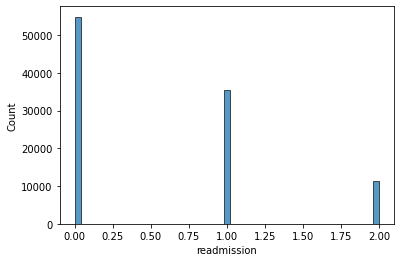

In [ ]:
sns.histplot(join_data['readmission'])

In [ ]:
pca_model          = PCA(n_components = 2)
x_pca              = pca_model.fit_transform(x_feature_selected)
explained_variance = pca_model.explained_variance_ratio_ # ~ 80 % by PCA 1 and 2

**PCA Plots**
1. No Visual Separation with 2 PC's
2. Tried Dropping Diagnostics and w/ Diagnostics
3. Running PCA on a reduced dataset is pointless --> PCA pretty much does the reduction and the plot looks the same because removed variables have very low weights in the PC's


Text(0.5, 0, 'PC1 (61.51%)')

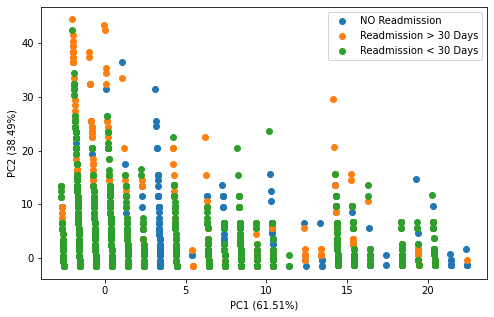

In [ ]:
fig           = plt.figure(0, figsize = (8,5))
# ymax      = 50
# xmax      = 100

# Legend Won't Show Without Loop
target_classes = np.unique(target_factorized)
for label in target_classes:
  plt.scatter(x_pca[target_factorized==label, 0], \
              x_pca[target_factorized==label, 1], label = label)

admission_titles = ['NO Readmission', 'Readmission > 30 Days', 'Readmission < 30 Days']
plt.legend(admission_titles)
plt.ylabel('PC2 ({}%)'.format(round(explained_variance[1] * 100, 2)))
plt.xlabel('PC1 ({}%)'.format(round(explained_variance[0] * 100, 2)))

**Plotting Seperately**

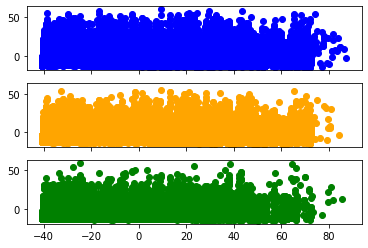

In [ ]:
fig, ax = plt.subplots(3, sharey = True, sharex = True)

ax[0].scatter(x_pca[target_factorized == target_classes[0],0], \
              x_pca[target_factorized == target_classes[0], 1], \
              label = target_classes[0], color = ['blue'])

ax[1].scatter(x_pca[target_factorized == target_classes[1], 0], \
              x_pca[target_factorized == target_classes[1], 1], \
              label = target_classes[1], color = ['orange'])

ax[2].scatter(x_pca[target_factorized == target_classes[2], 0], \
              x_pca[target_factorized == target_classes[2], 1],\
              label = target_classes[1], color = ['green'])


**Feature Selection**

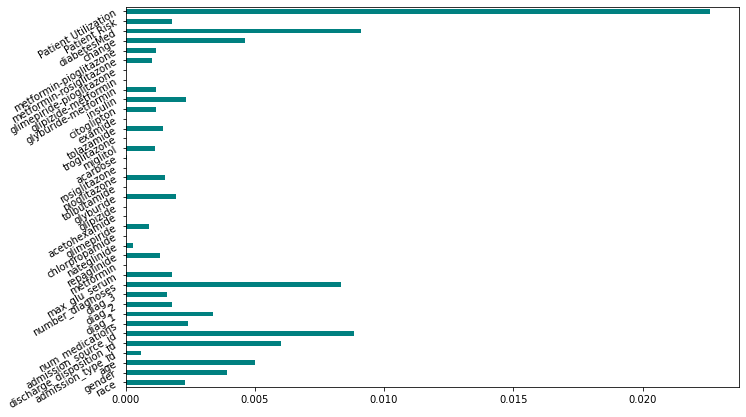

In [ ]:
from   sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

fig              = plt.figure(figsize = (11, 7))
importances      = mutual_info_classif(x_training, target_factorized)
feat_importances = pd.Series(importances, x_training.columns[:len(x_training.columns)])
feat_importances.plot(kind='barh', color = 'teal')
plt.yticks(rotation = 30)
plt.show()

**Variables That Seem To Be Important from Mutual Class Info Test**
1. Number of Inpatient (visits to hospital)
2. Diabetes Medication (Taking Meds Yes or No)
3. Number of Emergency
4. Change
5. Gender
6. Discharge Disposition ID


**Pearson's Correlation Coefficient**

In [ ]:
hmap_figure = plt.figure(figsize = (11, 7))
sns.heatmap(x_training.corr())

**Fischer's Score**

In [ ]:
!pip install skfeature-chappers

In [ ]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt

# Calculating scores
ranks            = fisher_score.fisher_score(x_training, target_factorized) # plot the ranks
feat_importances = pd.Series(ranks, x_training.columns)
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

**Checking High Variance Variables before Discretization**
1. Variance Threshold = 1 produces ~ 58% accuracy
2. All Features produces ~ 55%
3. Variance Treshold  = 2 produces ~ 56% accuracy
4. Variance Threshold = 3 produces ~ 55% accuracy
5. Variance Threshold = 0.5 produces ~ 59% accuracy
6. Variance Threshold = 0 produces ~ 59% accuracy

**Variables That Could Be Descritized**
1. Discharge Disposition ID(Depending on meaning) (30 max)
2. Time in hospital (15 max)
3. Num Lab Procedures (130 max)
4. Num Medications (80 max)
5. Number outpateints and inpatinet

In [ ]:
unique_variables = [len(x_data[col].unique()) for col in x_data.columns]
plt.hist(unique_variables, range = (0,80), bins = 10)
plt.ylabel('Number of Variables')
plt.xlabel('Unique Values')

In [ ]:
[x_training[col].unique() for col in x_training]

**Random Forest Classifier**

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100, verbose = True)
random_forest.fit(x_train, y_train)

predictions = random_forest.predict(x_test)
accuracy_score(predictions, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


0.5714847204480692

# Section XX: XGBoost Model
Regularization (overfitting prevention) Parameters:
1. Sub Sample (0.1-1)
2. Cal Sample by Level (0.1-1)
3. Cal Sample by Tree (0.1-1)
4. Min-childweight
5. lambda-yalp

In [ ]:
if binary_targets:
  objective = 'binary:logistic'
else:
  objective = 'multi:softmax'


xgb_model         = xgb.XGBClassifier(n_estimators = 50, learning_rate = 0.1,
                              objective   = objective,
                              min_child_weight = 0, reg_alpha = 20, reg_lambda = 35)

model_fits        = xgb_model.fit(x_train, y_train,
                    eval_set = [(x_train, y_train),(x_val, y_val)],
                    verbose = False)

xgb_predictions   = xgb_model.predict(x_test)
accuracies        = [accuracy_score(y_test, xgb_predictions)]
accuracy_score(y_test, xgb_predictions)

NameError: name 'xgb' is not defined

In [ ]:
def plot_losses():

  loss                = xgb_model.evals_result()
  training_loss       = dict(loss['validation_0'])['mlogloss']
  validation_loss     = dict(loss['validation_1'])['mlogloss']

  plt.plot(range(1, len(training_loss)+1), training_loss, label = 'Training')
  plt.plot(range(1, len(validation_loss)+1), validation_loss, label = 'Validation')
  plt.xlabel('Training Cycles (N_estimators)')
  plt.legend()

  return

plot_losses()

**Hyperparameter Optimization**

In [ ]:
reduced_length = 5000 # For Computing Reasons (On Faster Computer can remove this)
x_train_red    = x_train[0:reduced_length]
y_train_red    = y_train[0:reduced_length]

# output of function needs to minimzied
# for a classification problem, were minimizing the accuracy
# so in theory, it's really just having a metric that calculates the accuracy
# then that accuracy is being maximzied in a bayesian fassion
def bayes_opt(n_estimators, subsample, learning_rate, max_depth, colsample_bytree, eta):

  folds     = 5
  skf       = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

  params_gbm                     = {}
  params_gbm['learning_rate']    = learning_rate
  params_gbm['n_estimators']     = int(n_estimators)
  # params_gbm['reg_lambda']       = reg_lambda
  # params_gbm['reg_alpha']        = reg_alpha
  # params_gbm['gamma']            = round(gamma)
  params_gbm['subsample']        = subsample
  params_gbm['max_depth']        = int(max_depth)
  params_gbm['colsample_bytree'] = colsample_bytree
  params_gbm['eta']              = eta


  weights      = class_weight.compute_sample_weight('balanced', y_train)

  scores       = []
  for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_red, y_train_red)):

    x_train_fold, y_train_fold = pd.DataFrame(x_train_red).iloc[train_idx], pd.DataFrame(y_train_red).iloc[train_idx]
    x_val, y_val = pd.DataFrame(x_train_red).iloc[val_idx], pd.DataFrame(y_train_red).iloc[val_idx]
    watchlist = [(x_train_fold, y_train_fold), (x_val, y_val)]

    scorer     = make_scorer(log_loss)

    xgb_model  = XGBClassifier(**params_gbm,
                               objective = 'multi:softmax',
                               eval_metric = 'mlogloss')

    xgb_model.fit(x_train_fold, y_train_fold)

    val_preds  = xgb_model.predict_proba(x_val)
    score      = log_loss(y_val, val_preds)
    scores.append(score)



  scores = np.average(scores)


  # maximize 1- logloss (minimize logloss)

  return 1 - scores



pbounds = {'n_estimators': (100, 500),
          'subsample': (0.6, 1.0),
          'learning_rate':(0.01, 3),
           'max_depth': (3, 10),
           'colsample_bytree': (0.5, 1),
           'eta': (0.2, 0.4)
          }

optimizer   = BayesianOptimization(
    f       = bayes_opt,
    pbounds = pbounds,
    verbose = 2
)

optimizations = optimizer.maximize(
    init_points=4,
    n_iter=100,
)

|   iter    |  target   | colsam... |    eta    | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------


XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

**XGB Model 2**
1. 3 features accuracy ~ 58.3 % pretransofmrations 10 Aug 2023
2. Feature Engineering Patient Risk and Utilization and Keeping original variables raises accuracy to 58.6 % (seed dependent likely)


In [ ]:
feature_selection = True    # variable to determine if features are reduced earlier
feature_selection = FeatureSelection(x_training, target_factorized, 'boruta')

x_trains, x_tests, y_trains, y_tests = feature_selection.feature_selector()

# if feature_selection:
#   x_train, x_test, y_train, y_test = train_test_split(x_feature_selected, target_factorized, test_size = 0.2, shuffle = True)
# else:
#   x_train, x_test, y_train, y_test = train_test_split(x_training, target_factorized, test_size = 0.2, shuffle = True)



def create_XGBoost(model_type = 'default'):

  if binary_targets:
    objective   = 'binary:logistic'
    eval_metric = 'logloss'
  else:
    objective   = 'multi:softmax'
    eval_metric = 'mlogloss'

  colsample_bytree = 1
  learning_rate    = 0.01
  eta              = 0.4
  max_depth        = 5
  n_estimators     = 493
  subsample        = 0.6

  if model_type == 'default':
    xgb_model = XGBClassifier(eval_metric = eval_metric, objective = objective)
  else:
    xgb_model  = XGBClassifier(colsample_bytree = 1, learning_rate = 0.01, eta = 0.4,
                            max_depth = 5, n_estimators = 493, subsample = 0.6,
                            objective = objective, eval_metric = eval_metric)

  return xgb_model


if isinstance(x_trains, list):
  for feat in range(len(x_trains)):
    print(feat, range(len(x_trains)))
    xgb_model  = create_XGBoost()
    xgb_model.fit(x_trains[feat], y_trains[feat])
    predictions = xgb_model.predict(x_tests[feat])
    accuracy    = accuracy_score(predictions, y_tests[feat])
    print(accuracy, feat + 2)
else:

  xgb_model  = create_XGBoost()
  forest     = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

  # Define Boruta feature selection method
  boruta_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=42)

  # Find relevant features
  boruta_selector.fit(np.array(x_trains), np.array(y_trains))

  # Check selected features
  selected_features = np.where(boruta_selector.support_)[0]
  print(f"Selected features: {selected_features}")

  # Optionally, you can transform the dataset to only include selected features:
  X_filtered  = boruta_selector.transform(np.array(x_trains))
  x_tests     = boruta_selector.transform(np.array(x_tests))

  xgb_model.fit(X_filtered, y_trains)
  predictions = xgb_model.predict(x_tests)
  accuracy    = accuracy_score(predictions, y_tests)
  print(accuracy)




In [ ]:
# Base Nueral Network to investigate baseline performance
# Output is no readmission, readmission within 30 days, and readmission > 30 days

def build_nueralnet(node_size = 128):

  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(node_size, input_shape = (x_train.shape[1],), activation = 'relu'),
      tf.keras.layers.Dense(node_size/2, activation = 'relu'),
      tf.keras.layers.Dense(node_size/4, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(node_size/4, activation = 'relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(3, activation = 'softmax')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

  model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy', optimizer = optimizer)
  model.summary()

  return model


epochs = 20

model = build_nueralnet()
model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
def filter_pred(predictions):

  prediction_list     = []
  for pred in predictions:
    prob_1 = pred[0]
    prob_2 = pred[1]
    prob_3 = pred[2]

    values     = [prob_1, prob_2, prob_3]
    max_val    = max(values)
    prediction = values.index(max_val)

    prediction_list.append(prediction)

  return prediction_list


pred_filtered = filter_pred(predictions)



In [ ]:
def pred_by_group():
  prediction_counts = pd.Series(pred_filtered).value_counts()
  actual_counts     = pd.Series(y_test).value_counts()

  accuracies = {}
  for val in range(len(prediction_counts)):
    accuracy = prediction_counts[val]/actual_counts[val]
    accuracies[val] = accuracy


  return accuracies


pred_by_group()

In [ ]:
accuracy_score(pred_filtered, y_test)

# Section XX: Nueral Networks with Keras Functional API



In [ ]:
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy

In [ ]:
# Identify the columns with many features
# For a separate input with embedding layers

def identify_embeddings(x_data, min_features = 30):

  embedding_features     = []
  threshold_counts       = 10

  for col in x_train:
    value_counts         = x_train[col].value_counts()
    if len(value_counts) > min_features:
      embedding_features.append(col)

  return embedding_features


feature_selection = False    # variable to determine if features are reduced earlier

if feature_selection:
  embedding_features               = identify_embeddings(x_feature_selected)
  x_train, x_test, y_train, y_test = train_test_split(x_feature_selected, target_factorized, test_size = 0.2, shuffle = True)
else:
  embedding_features               = identify_embeddings(x_training)
  x_train, x_test, y_train, y_test = train_test_split(x_training, target_factorized, test_size = 0.2, shuffle = True)

x_train_emb   = x_train[embedding_features]
x_test_emb    = x_test[embedding_features]

x_train_norm  = x_train[[col for col in x_train if col not in embedding_features]]
x_test_norm   = x_test[[col for col in x_test if col not in embedding_features]]

In [ ]:
import tensorflow as tf
from   tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate, Dropout

def parallel_input_model(x_train_emb, x_train_norm):
  # Define input for high cardinality features
  embedding_num          = x_train_emb.shape[1]

  input_high_cardinality = []  # List to store input layers for each high cardinality feature
  embeddings             = []

  input_dims             = [x_train_emb[col].max() for col in x_train_emb]


  # Create an embedding for each high cardinality feature
  for index in range(embedding_num):
      # Define a separate input layer for each feature
      input_high_cardinality_feature = Input(shape=(1,))
      input_high_cardinality.append(input_high_cardinality_feature)

      embedding_size    = min(50, int(input_dims[index] ** 0.5))  # A common heuristic for embedding size
      input_dim         = input_dims[index]
      print(input_dim, embedding_size)

      embedded          = Embedding(input_dim=input_dim + 1,  # Assuming a max of 1000 categories for simplicity
                          output_dim=embedding_size)(input_high_cardinality_feature)
      embedded          = Flatten()(embedded)
      embeddings.append(embedded)

  # Merge all the embeddings
  merged_embeddings     = concatenate(embeddings)

  # Define input for lower cardinality/continuous features
  low_cardinality       = x_train_norm.shape[1]
  input_low_cardinality = Input(shape= low_cardinality,)  # Assuming 14 other features

  # Concatenate both the inputs
  x                     = concatenate([merged_embeddings, input_low_cardinality])
  x                     = Dense(256, activation='relu')(x)
  x                     = Dropout(0.4)(x)
  x                     = Dense(256, activation='relu')(x)
  x                     = Dense(128, activation = 'relu')(x)
  x                     = Dropout(0.4)(x)
  x                     = Dense(32, activation = 'relu')(x)
  output                = Dense(3, activation='softmax')(x)

  optimizer             = tf.keras.optimizers.Adam(learning_rate = 0.001)
  model                 = tf.keras.Model(inputs=input_high_cardinality + [input_low_cardinality], outputs=output)
  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model = parallel_input_model(x_train_emb, x_train_norm)

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
!pip install xgboost

In [ ]:
def fit_model():
  epochs    = 5
  val_split = 0.2
  verbose   = 2
  # x_train_emb, x_test_emb = np.array(x_train_emb), np.array(x_test_emb)

  x_data    = [np.array(x_train_emb[col]) for col in x_train_emb.columns]
  x_data.append(np.array(x_train_norm))

  history = model.fit(x_data, y_train, epochs = epochs, validation_split = val_split)

  return history

history  = fit_model()

In [ ]:
def predict_accuracy(x_test_emb, x_test_norm):
  x_test_data = [np.array(x_test_emb[col]) for col in x_train_emb.columns]
  x_test_data.append(np.array(x_test_norm))
  predictions = model.predict(x_test_data)

  pred_filtered = filter_pred(predictions)
  accuracy      = accuracy_score(pred_filtered, y_test)

  return accuracy

predict_accuracy(x_test_emb, x_test_norm)

# Section XX: Creating Multiple Models
1. accuracy is not above 60% so perhaps splitting up classificaton tasks may help
2. Creating 2 classes lowers the accuracy... this is not a good approach


In [ ]:
# Splitting Data into readmitted vs. not readmitted
def create_binary_targets(targets):
  classifications  = targets.unique()
  no_readmission   = classifications[0]
  readmitted_class = classifications[1:]

  binary_targets   = {}               # Keep track of original labels and new labels
  binary_list      = []
  for classification in classifications:
    binary_targets[classification]   = []


  for classification in targets:
    if classification in no_readmission:
      selection    = 0
    else:
      selection    = 1

    binary_targets[classification].append(selection)
    binary_list.append(selection)

  return binary_targets, binary_list


# binary_target_dict, binary_list = create_binary_targets(targets)
# target_list        = list(binary_target_dict.values())
# binary_list        = np.array(binary_list)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x_feature_selected, binary_list, test_size = 0.2, shuffle = True)


In [ ]:
# def build_xgb_model():
#   xgb_model  = XGBClassifier(colsample_bytree = 1, learning_rate = 0.01, eta = 0.4,
#                             max_depth = 5, n_estimators = 493, subsample = 0.6,
#                             objective = 'binary:logistic', eval_metric = 'mlogloss')

#   xgb_model.fit(x_train, y_train)
#   predictions = xgb_model.predict(x_test)
#   accuracy_score(predictions, y_test)


#   return xgb_model


# xgb_model = build_xgb_model()

In [ ]:
xgb_model.predict(x_test)

# Section XX: Miscellenous Code

**SMAC always minimized target function (train return statement)**

In [ ]:
!pip install smac

In [ ]:
# from xgboost.sklearn import XGBClassifier
# from ConfigSpace import Configuration, ConfigurationSpace

# import numpy as np
# from smac import HyperparameterOptimizationFacade, Scenario

# def train(config: Configuration, seed: int = 0) -> float:
#     classifier = XGBClassifier(n_estimators = config['estimators'], random_state=seed,
#                                reg_alpha = config['reg_alpha'], objective = 'multi:softmax',
#                                reg_lambda = config['reg_lambda'], learning_rate = config['lr'])
#     print('hello')

#     # scores = cross_val_score(classifier, x_data, target_factorized, cv=5)
#     classifier.fit(x_train, y_train)
#     predictions = classifier.predict(x_test)
#     accuracy    = accuracy_score(predictions, y_test)
#     return 1 - accuracy

# configspace = ConfigurationSpace({"estimators": (50, 150),
#                                   'reg_alpha': (0, 100),
#                                   'reg_lambda': (0, 100),
#                                   'lr': (0, 1)})

# # Scenario object specifying the optimization environment
# scenario = Scenario(configspace, deterministic=True, n_trials=25, walltime_limit=600)

# # Use SMAC to find the best configuration/hyperparameters
# smac      = HyperparameterOptimizationFacade(scenario, train)
# incumbent = smac.optimize()


In [ ]:
classifier = XGBClassifier(n_estimators = 133, random_state = 0,
                               reg_alpha = 22, objective = 'multi:softmax',
                               reg_lambda = 51, learning_rate = 1)

# scores = cross_val_score(classifier, x_data, target_factorized, cv=5)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
accuracy = accuracy_score(predictions, y_test)
accuracy